### Heteroskedastic noise BNN_LV with PYMC3
Using NUTS in pymc3 to sample from posterior of BNN_LV

Samples saved out: `saved_samples/hsc_samples_pymc3.npy`

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import wandb
import pymc3 as pm
import theano.tensor as tt
from IPython.core.debugger import set_trace
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from utils.data_gen import sample_gaussian_mixture, generate_regression_outputs
from utils.BNN_pymc3 import BNN_LV as BNN_LV_pymc3
from utils.custom_callbacks_pymc3 import plot95ci, wb_scatter, build_wb_callback

# Heteroskedastic Noise

### Generate data

In [3]:
y_hsc, X_hsc = generate_regression_outputs(type='hsc')

### Setup BNN_LV architecture and perform MLE fit

In [4]:
# Parameters
gamma = 1
sigma = 1

architecture = {'input_n':1, 
             'output_n':1, 
             'hidden_layers':[20,20],
             'biases' : [1,1,1],
             'activations' : ['relu', 'relu', 'linear'],
             'gamma':[gamma],
             'sigma':[sigma]}
bnn_lv = BNN_LV_pymc3(architecture=architecture)

bnn_lv.fit(X_hsc, y_hsc, step_size=0.01, max_iteration=5000, check_point=500, regularization_coef=None)

Iteration 0 lower bound 92.4784640788641; gradient mag: 671.8176600930491
Iteration 500 lower bound 3.505640121636584; gradient mag: 1.1185112675381683
Iteration 1000 lower bound 3.447198800477059; gradient mag: 1.6887614092790066
Iteration 1500 lower bound 3.37164983595188; gradient mag: 0.15951352595274332
Iteration 2000 lower bound 3.3479439400526547; gradient mag: 0.24431668435760323
Iteration 2500 lower bound 3.3331093571379666; gradient mag: 1.0877975215482003
Iteration 3000 lower bound 3.331978582796932; gradient mag: 10.058986608118829
Iteration 3500 lower bound 3.3215986876873687; gradient mag: 11.004445628341177
Iteration 4000 lower bound 3.2965579687776856; gradient mag: 4.238730121804224
Iteration 4500 lower bound 3.3641939245027364; gradient mag: 26.24332582493811


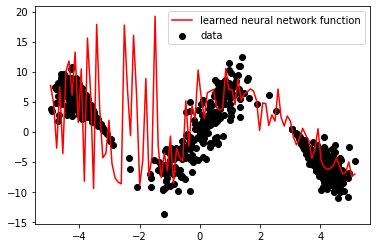

In [5]:
x_test = np.linspace(min(X_hsc), max(X_hsc), 100).reshape((1, -1))

#predict on the test x-values
y_test_pred = bnn_lv.forward(x_test.reshape(100,1))

#visualize the function learned by the neural network
plt.scatter(X_hsc.flatten(), y_hsc.flatten(), color='black', label='data')
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

### Prepare parameters for pymc3 sampling

In [7]:
# variable parameters
p_mu = 0
p_sigma = 5
l_sigma = 0.25
lv_gamma = 1

# pymc3 NUTS parameters
my_tune = 2000
my_draws = 1500
my_target_accept = 0.9
my_max_treedepth = 12


nn = bnn_lv
X_test = np.linspace(min(X_hsc), max(X_hsc), 100).reshape((1, -1))

# Initialize a W&B run:
wandb.init(
    entity    = 'gpestre',  # Don't change this.
    project   = 'am207',  # Don't change this.
    group     = 'pymc3_hsc',
    name      = 'hsc_attempt',
    notes     = 'increasing target accept and maxtreedepth',
    config    = {
        # Manually archive info about network and priors.
        'architecture' : architecture,
        'p_mu' : p_mu,
        'p_sigma' : p_sigma,
        'l_sigma' : l_sigma,
        'lv_gamma' : lv_gamma,
        'tune' : my_tune,
        'draws' : my_draws,
        'max_treedepth': my_max_treedepth,
        'target_accept': my_target_accept,
    },
)

wb_callback = build_wb_callback(nn=bnn_lv, X=X_hsc, iters_log=50, iters_plot=250)

### Run pymc3

In [ ]:
with pm.Model() as pm_model:
    
    # prior on w (same shape as MLE)
    w_prior = pm.Normal('w', mu=p_mu, sigma=p_sigma, shape=bnn_lv.weights.shape) 
    
    # Latent variable prior (same shape as number of datapoints)
    lv_prior = pm.Normal('z', mu=0, sigma=lv_gamma, shape=(X_hsc.shape[0],1))
        
    # Y with X,LV
    y = pm.Normal('y', mu = bnn_lv.forward(X = X_hsc, input_noise = lv_prior, weights=w_prior),
                       sigma = l_sigma,
                       observed = y_hsc)
    
    # NUTS sampling
    trace = pm.sample(tune=my_tune, draws=my_draws, start = {'w': bnn_lv.weights},
                      target_accept = my_target_accept, max_treedepth = my_max_treedepth,
                      callback=wb_callback)

In [ ]:
wb_scatter(nn=nn, X=X_test, trace_w=trace['w'])

wandb.finish()

### Complete sampling and save/load samples obtained

In [8]:
# 6 hrs
# np.save('saved_samples/hsc_samples_pymc3.npy', trace['w'])
posterior_samples_pymc3_hsc = np.load('saved_samples/hsc_samples_pymc3.npy')

In [9]:
posterior_samples_pymc3_hsc.shape

(6000, 1, 501)